In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd
import os

# (Element Name, File Path, Rows to Skip, Column Name in file)
FILE_MAPPINGS = [
    ("TG", "./data/TG_SOUID121044.txt", 20, "   TG"), # Mean Temp
    ("TN", "./data/TN_SOUID121045.txt", 20, "   TN"), # Min Temp
    ("TX", "./data/TX_SOUID121046.txt", 20, "   TX"), # Max Temp
    ("RR", "./data/RR_SOUID121042.txt", 20, "   RR"), # Rain
    ("SS", "./data/SS_SOUID121040.txt", 20, "   SS"), # Sunshine
    ("HU", "./data/HU_SOUID121047.txt", 20, "   HU"), # Humidity
    ("FG", "./data/FG_SOUID121048.txt", 20, "   FG"), # Wind Speed
    ("CC", "./data/CC_SOUID121039.txt", 20, "   CC"), # Cloud Cover
    ("SD", "./data/SD_SOUID121043.txt", 20, "   SD"), # Snow Depth
]

all_dfs = []

# 2. The Loop: Reading files one by one
for element, file_path, skip, col_name in FILE_MAPPINGS:
    if os.path.exists(file_path):
        # Read the file
        temp_df = pd.read_csv(
            file_path, 
            skiprows=skip, 
            usecols=["    DATE", col_name], 
            parse_dates=["    DATE"], 
            na_values=["-9999"]  # Turns -9999 into NaN (Empty)
        )
        
        # Rename columns to be pretty
        temp_df.rename(columns={col_name: element, "    DATE": "DATE"}, inplace=True)
        temp_df.set_index("DATE", inplace=True)
        
        # Add to our list
        all_dfs.append(temp_df)
    else:
        print(f"⚠️ Missing file: {file_path}")

# 3. The Merge
if all_dfs:
    df = pd.concat(all_dfs, axis=1).sort_index()
    
    # Quick cleaning (Fill gaps with yesterday's data)
    df = df.ffill()
    
    # Filter: Let's only keep data up to yesterday (to avoid empty future dates)
    df = df[df.index < pd.Timestamp.now()]
    
    print("✅ DONE! Data is ready.")
    print(f"Range: {df.index.min().date()} to {df.index.max().date()}")
    print(f"Shape: {df.shape} (Rows, Columns)")
else:
    print("❌ ERROR: No data found. Check your folder path!")

✅ DONE! Data is ready.
Range: 1931-01-01 to 2025-09-30
Shape: (34607, 9) (Rows, Columns)


In [3]:
# Find the first day that actually has Temperature (TG) data
start_date = df['TG'].first_valid_index()
print(f" Real Temperature data starts on: {start_date}")

# Slice the data to start from that day onwards
df = df.loc[start_date:]

# Check the head again
df.head()

 Real Temperature data starts on: 1957-09-01 00:00:00


,TG,TN,TX,RR,SS,HU,FG,CC,SD
DATE,,,,,,,,,
1957-09-01,144.0,119.0,168.0,76.0,NaN,92.0,21.0,8.0,0.0
1957-09-02,132.0,105.0,179.0,20.0,NaN,83.0,32.0,6.0,0.0
1957-09-03,123.0,57.0,169.0,0.0,NaN,80.0,16.0,6.0,0.0
1957-09-04,126.0,60.0,197.0,0.0,NaN,79.0,16.0,7.0,0.0
1957-09-05,164.0,110.0,203.0,65.0,NaN,87.0,28.0,7.0,0.0


In [4]:
# 1. Create a copy so we don't mess up the original
model_df = df.copy()

# 2. CREATE THE TARGET
# "shift(-1)" pulls the next day's value up to the current row
model_df['Target'] = model_df['TG'].shift(-1)

# 3. The last day has no "tomorrow", so it's Empty (NaN). Drop it.
model_df.dropna(inplace=True)

# See how 'Target' is different from 'TG'
model_df[['TG', 'Target']].head()

#model_df.head()

,TG,Target
DATE,,
1957-10-01,56.0,57.0
1957-10-02,57.0,83.0
1957-10-03,83.0,58.0
1957-10-04,58.0,93.0
1957-10-05,93.0,108.0


In [5]:
from sklearn.model_selection import train_test_split

# Define Features (X) and Target (y)
# X = Everything EXCEPT the target
X = model_df.drop(columns=['Target'])
# y = Only the target
y = model_df['Target']

# SPLIT! 
# shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training on {len(X_train)} days")
print(f"Testing on {len(X_test)} days")


Training on 19868 days
Testing on 4968 days


In [6]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- 1. Training ---
# n_estimators=100: Build 100 decision trees
# n_jobs=-1: Use all CPU cores for speed 
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

print("🌲 Training the Random Forest...")
rf_model.fit(X_train, y_train) 

# --- 2. THE PREDICTION ---
print("🔮 Predicting the future...")
raw_predictions = rf_model.predict(X_test)

# --- 3. UNIT CONVERSION ---
# ECAD data stores temperature as integers (e.g., 123 = 12.3°C).
# We divide by 10 to convert raw data into real Celsius degrees.
y_test_real = y_test / 10.0
predictions_real = raw_predictions / 10.0

# --- 4. THE REPORT CARD (Evaluation) ---
# Calculate scores using the REAL Celsius values
score = r2_score(y_test_real, predictions_real)
mse = mean_squared_error(y_test_real, predictions_real)
rmse = np.sqrt(mse) # RMSE = Root Mean Squared Error

print(f"\n✅ Estimation")
print(f"Model Accuracy (R2): {score:.4f} (1.0 is perfect)")
print(f"Average Error:      {rmse:.2f} °C") 


🌲 Training the Random Forest...
🔮 Predicting the future...

✅ Estimation
Model Accuracy (R2): 0.8944 (1.0 is perfect)
Average Error:      2.15 °C


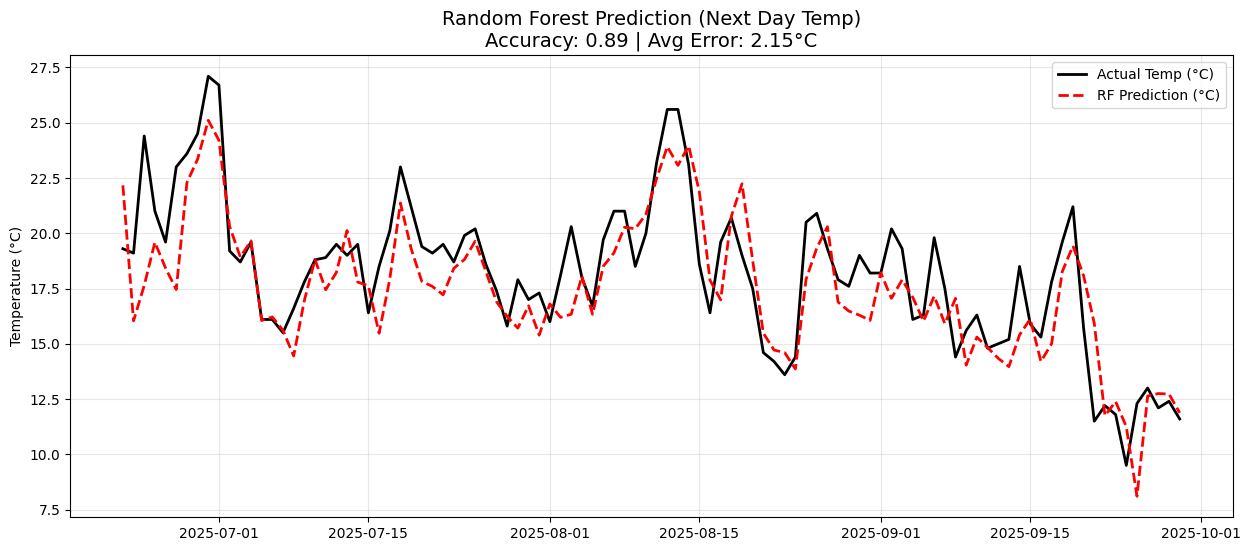

In [7]:
# --- Visualization ---
# Plotting only the last 100 days for clarity
plt.figure(figsize=(15, 6))

# Plot Actual Temperature (Black)
plt.plot(y_test_real.index[-100:], y_test_real.values[-100:], 
         color='black', label='Actual Temp (°C)', linewidth=2)

# Plot Predicted Temperature (Red Dashed)
plt.plot(y_test_real.index[-100:], predictions_real[-100:], 
         color='red', linestyle='--', label='RF Prediction (°C)', linewidth=2)

# Graph Formatting
plt.title(f'Random Forest Prediction (Next Day Temp)\nAccuracy: {score:.2f} | Avg Error: {rmse:.2f}°C', fontsize=14)
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()